In [1]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


### Labeling participants based on these four clusters

In [20]:
study = 2
baseMult = 4
precision = 100
model = 'MP_ppSOE'

In [21]:
# Create theta-phi space
decimals = int(np.log10(precision)+1)
if model == 'MP_ppSOE':
    phi = np.around(np.arange(-0.1,0.10001,0.2/precision).astype('float'),decimals=decimals)#[-.1,0,.1]
    theta = np.around(np.arange(0,.50001,.5/precision).astype('float'),decimals=decimals)#[0,.1,.2,.3,.4,.5,.6]
    phiLen = len(phi)
    thetaLen = len(theta)
    phi[np.floor(len(phi)/2).astype(int)]=0
    thetaPhi = np.repeat(theta,phiLen)
    thetaPhi = pd.DataFrame(thetaPhi)
    thetaPhi.columns = ['theta']
    thetaPhi['phi'] = np.tile(phi,thetaLen)
    print (len(thetaPhi))
    print (thetaPhi.head())

10201
   theta    phi
0    0.0 -0.100
1    0.0 -0.098
2    0.0 -0.096
3    0.0 -0.094
4    0.0 -0.092


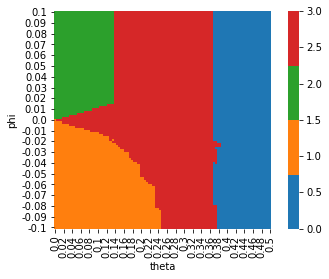

In [22]:
# Load clustering
fnstring = 'Study-%i'%study
if study == 1:
    fnstring = fnstring + '_baseMult-%i'%baseMult
thetaPhi = pd.read_csv(base_dir + '/Data/Study%i/ComputationalModel'%study +
            '/ClusteringMapMelted_%s_model-%s_precision-100.csv'%(fnstring,model))
if study == 1:
    if baseMult == 4:
        key = {0:'GR',1:'GA',2:'MO',3:'IA'}
    elif baseMult == 6:
        key = {0:'GR',1:'MO',2:'IA',3:'GA'}
elif study == 2:
    key = {0:'GR',1:'GA',2:'IA',3:'MO'}
thetaPhiPivot = thetaPhi.pivot('theta','phi','cluster').T
fig = sns.heatmap(thetaPhiPivot,square=True,cmap=sns.color_palette('tab10',4))
fig.invert_yaxis()
plt.show()

In [24]:
# Load fitted parameters
model = 'MP_ppSOE'
fittedParams = pd.read_csv(os.path.join(base_dir,'Data/Study%i/ComputationalModel/Results_study%i.csv'%(study,study)),index_col=0)
if study == 1:
    fittedParams = fittedParams.loc[(fittedParams['baseMult']==baseMult)].reset_index(drop=True)
fittedParams = fittedParams.loc[(fittedParams['model']==model)].reset_index(drop=True)
fittedParams.head()

,sub,model,theta,phi,SSE,AIC,BIC
0,152,MP_ppSOE,0.028962,0.040325,194.0,75.221486,79.882953
1,153,MP_ppSOE,0.031704,0.036484,353.0,120.715838,125.377305
2,154,MP_ppSOE,0.030322,0.000436,437.0,136.939189,141.600656
3,155,MP_ppSOE,0.059885,-0.007584,730.0,175.935651,180.597117
4,156,MP_ppSOE,0.205909,-0.081125,408.0,131.720571,136.382038


In [27]:
# Add cluster to subjects
fittedParams['clust'] = 0
for i in range(len(fittedParams)):
    thetaPhiDist = thetaPhi.copy()
    thetaPhiDist['euclidist'] = np.sqrt(np.square(fittedParams['theta'][i] - thetaPhi['theta']) +
                                        np.square(fittedParams['phi'][i] - thetaPhi['phi']))
    nearest = np.where(thetaPhiDist['euclidist'] == min(thetaPhiDist['euclidist']))[0][0]
    fittedParams.loc[i,'clust'] = thetaPhiDist['cluster'].iloc[nearest]
fittedParams['ClustName'] = fittedParams['clust'].map(key)
display (fittedParams.head())
if study == 1:
    fittedParams.to_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                                     'ParamsClusters_study-1_baseMult-%i_model-%s_precision-%i.csv'%(
                            baseMult,model,precision)))
elif study == 2:
    fittedParams.to_csv(os.path.join(base_dir,'Data/Study2/ComputationalModel',
                            'ParamsClusters_study-2_model-%s_precision-%i.csv'%(
                            model,precision)))

,sub,model,theta,phi,SSE,AIC,BIC,clust,ClustName
0,152,MP_ppSOE,0.028962,0.040325,194.0,75.221486,79.882953,2,IA
1,153,MP_ppSOE,0.031704,0.036484,353.0,120.715838,125.377305,2,IA
2,154,MP_ppSOE,0.030322,0.000436,437.0,136.939189,141.600656,3,MO
3,155,MP_ppSOE,0.059885,-0.007584,730.0,175.935651,180.597117,1,GA
4,156,MP_ppSOE,0.205909,-0.081125,408.0,131.720571,136.382038,1,GA


In [28]:
fittedParams['ClustName'].value_counts()

MO    25
IA    17
GA    11
GR     2
Name: ClustName, dtype: int64

### Plot participants scattered on parameter space

In [30]:
# Define colors
sns.set_palette('tab10',4,desat=.8)
weight_colorsByWhites = [3,1]
colorMap = sns.color_palette()[0:4]
colorMap = list(np.add(np.multiply(colorMap,weight_colorsByWhites[0]),
                       np.multiply(np.ones([4,3]),weight_colorsByWhites[1]))
                /sum(weight_colorsByWhites))
markers = ['o','*','s','d']
colors = sns.color_palette("tab10", 4,desat=.9)
edgecolors = np.divide(colorMap,1.5)
sizes = [50,100,50,75]
desiredOrder = ['GR','GA','IA','MO']

In [39]:
mapTransform = dict(zip(key.keys(),[list(key.values()).index(desiredOrder[i]) for i in range(len(desiredOrder))]))
mapTransform

background = thetaPhi.copy()
background['cluster'] = thetaPhi['cluster'].map(mapTransform)
background = background.pivot('theta','phi','cluster').T

0 GR o 50
1 GA * 100
2 IA s 50
3 MO d 75


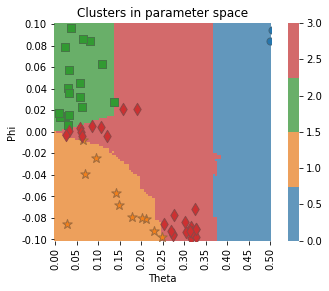

In [41]:
x_num = np.size(thetaPhiPivot,0)
y_num = np.size(thetaPhiPivot,1)
x_range = np.float(thetaPhiPivot.columns[x_num-1])-np.float(thetaPhiPivot.columns[0])
y_range = np.float(thetaPhiPivot.index[y_num-1])-np.float(thetaPhiPivot.index[0])
y_start = 0.1

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
sns.heatmap(background,ax=ax,cmap=colorMap)
ax.set_title('Clusters in parameter space')
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.invert_yaxis()
plt.yticks(np.arange(0.5,phiLen+1,(phiLen-1)/10),['%.2f'%i for i in np.arange(-.1,.1001,.2/(phiLen-1)*10)])
plt.xticks(np.arange(0.5,thetaLen+1,(thetaLen-1)/10),['%.2f'%i for i in np.arange(0,.5001,.5/(phiLen-1)*10)])

for clustInd,clustName in enumerate(desiredOrder):
    marker = markers[clustInd]; color = colors[clustInd];
    size = sizes[clustInd]; edgecolor = edgecolors[clustInd];
    print (clustInd,clustName,marker,size)
    thetaCur = fittedParams['theta'][fittedParams['ClustName']==clustName]
    phiCur = fittedParams['phi'][fittedParams['ClustName']==clustName]
    ax.scatter(x=.5+thetaCur/x_range*(x_num-1)+np.random.rand(1),y=.5+(y_start+phiCur)/y_range*(y_num-1),
               marker=marker,color=color,edgecolor=edgecolor,s=size,lw=1)